# Objectives
1. Find 10 countries with most cases of covid
2. Observe progression of covid-19 by continent
3. Investigate whether current level of vaccination is slowing down the spread or not
4. Determine where the vaccine is needed the most by looking at mortality rate & accumulated death counts

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from collections import OrderedDict
import pycountry_convert as pc
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode

In [2]:
covid = pd.read_csv(r"C:\Users\taewoo\PycharmProjects\data_professionals\Projects\Datasets\Covid-19 Activity.csv")
covid.head()

c:\users\taewoo\pycharmprojects\data-analysis-practice\venv\interpreter\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,18046,Kenosha,Wisconsin,2021-04-26,America,New York Times,0,55059.0,USA,United States,US,3,321
1,18096,Kenosha,Wisconsin,2021-04-27,America,New York Times,0,55059.0,USA,United States,US,50,321
2,18123,Kenosha,Wisconsin,2021-04-28,America,New York Times,1,55059.0,USA,United States,US,27,322
3,18148,Kenosha,Wisconsin,2021-04-29,America,New York Times,0,55059.0,USA,United States,US,25,322
4,18163,Kenosha,Wisconsin,2021-04-30,America,New York Times,0,55059.0,USA,United States,US,15,322


## Data Cleansing

In [3]:
# dropping columns that aren't too useful for this analysis
covid.drop(columns=['COUNTY_FIPS_NUMBER', 'DATA_SOURCE_NAME', 'COUNTRY_ALPHA_2_CODE'], inplace=True)
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687420 entries, 0 to 1687419
Data columns (total 10 columns):
 #   Column                           Non-Null Count    Dtype 
---  ------                           --------------    ----- 
 0   PEOPLE_POSITIVE_CASES_COUNT      1687420 non-null  int64 
 1   COUNTY_NAME                      1558424 non-null  object
 2   PROVINCE_STATE_NAME              1585556 non-null  object
 3   REPORT_DATE                      1687420 non-null  object
 4   CONTINENT_NAME                   1685516 non-null  object
 5   PEOPLE_DEATH_NEW_COUNT           1687420 non-null  int64 
 6   COUNTRY_ALPHA_3_CODE             1685516 non-null  object
 7   COUNTRY_SHORT_NAME               1687420 non-null  object
 8   PEOPLE_POSITIVE_NEW_CASES_COUNT  1687420 non-null  int64 
 9   PEOPLE_DEATH_COUNT               1687420 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 128.7+ MB


In [4]:
covid.isnull().sum()

PEOPLE_POSITIVE_CASES_COUNT             0
COUNTY_NAME                        128996
PROVINCE_STATE_NAME                101864
REPORT_DATE                             0
CONTINENT_NAME                       1904
PEOPLE_DEATH_NEW_COUNT                  0
COUNTRY_ALPHA_3_CODE                 1904
COUNTRY_SHORT_NAME                      0
PEOPLE_POSITIVE_NEW_CASES_COUNT         0
PEOPLE_DEATH_COUNT                      0
dtype: int64

In [5]:
def country_to_continent(country_name):
    '''
    return continent of a country
    
        Args:
            country_name (str) = name of a country
        Return:
            continent_name (str) = name of a continent
    '''
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return continent_name

# drop duplicates
covid.drop_duplicates(inplace=True)
# extract countries with nontype continent
country_of_nan_continent = covid[covid['CONTINENT_NAME'].isnull()]['COUNTRY_SHORT_NAME'].unique() 
# fill continents
for country in country_of_nan_continent:
    country_index = covid.loc[covid['COUNTRY_SHORT_NAME'] == country].index
    covid.loc[country_index, 'CONTINENT_NAME'] = country_to_continent(country)

# it's possible to find province if county can be found, not possible vice versa
print('county without null, province with null')
print(covid.loc[covid['COUNTY_NAME'].notnull() & covid['PROVINCE_STATE_NAME'].isnull()].shape[0])
print('county with null, province with null')
print(covid.loc[covid['COUNTY_NAME'].isnull() & covid['PROVINCE_STATE_NAME'].isnull()].shape[0])
print('county with null, province without null')
print(covid.loc[covid['COUNTY_NAME'].isnull() & covid['PROVINCE_STATE_NAME'].notnull()].shape[0])
print()

# I was unable to identify provinces and counties
covid.fillna('Unknown', inplace=True)
print(covid.isnull().sum())

county without null, province with null
0
county with null, province with null
101864
county with null, province without null
27132

PEOPLE_POSITIVE_CASES_COUNT        0
COUNTY_NAME                        0
PROVINCE_STATE_NAME                0
REPORT_DATE                        0
CONTINENT_NAME                     0
PEOPLE_DEATH_NEW_COUNT             0
COUNTRY_ALPHA_3_CODE               0
COUNTRY_SHORT_NAME                 0
PEOPLE_POSITIVE_NEW_CASES_COUNT    0
PEOPLE_DEATH_COUNT                 0
dtype: int64


## Total cases of Covid-19 by countries and provinces

In [6]:
def provincial_case(df, country):
    '''
    return a dictionary of all provincial cases
    
        Args:
            df (DataFrame): a dataframe with all information of countries and provinces
            country (str): any country in the dataframe
        Return:
            (OrderedDict): provinces and total cases
    '''
    country_table = df.loc[df['COUNTRY_SHORT_NAME'] == country]
    province_list = country_table['PROVINCE_STATE_NAME'].unique()
    province_dict = dict()
    for province in province_list:
        province_dict[province] = country_table.loc[country_table['PROVINCE_STATE_NAME'] == province]['PEOPLE_POSITIVE_CASES_COUNT'].max()
    return OrderedDict(sorted(province_dict.items(), key=lambda x: x[1], reverse=True))


def country_case(df, country):
    '''
    return the sum of *confirmed* cases of Covid-19 in a country
    
        Args:
            df (DataFrame): a dataframe with all information of countries
            country (str): any country in the dataframe
        Return:
            country (str): input country
            total (int): total of confirmed cases 
    '''
    country_df = df.loc[df['COUNTRY_SHORT_NAME'] == country]
    total = country_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].sum()
    return country, total


every_country = covid['COUNTRY_SHORT_NAME'].unique()
country_cases = dict()

for country in every_country:
    country, total_case = country_case(covid, country)
    country_cases[country] = total_case

country_cases = OrderedDict(sorted(country_cases.items(), key=lambda x: x[1], reverse=True))

print('Total cases of Covid-19 by countries')
print(country_cases)
print()
print('Test - Provincial cases in Canada')
print(provincial_case(covid, 'Canada'))

Total cases of Covid-19 by countries
OrderedDict([('United States', 32772514), ('India', 22992517), ('Brazil', 15209990), ('France', 5730585), ('Turkey', 5044936), ('Russia', 4832959), ('United Kingdom', 4437217), ('Italy', 4116287), ('Spain', 3581392), ('Germany', 3538208), ('Argentina', 3165121), ('Colombia', 3015301), ('Poland', 2835083), ('Iran', 2673219), ('Mexico', 2366496), ('Ukraine', 2178095), ('Peru', 1850290), ('Indonesia', 1718575), ('Czechia', 1645448), ('South Africa', 1597724), ('Netherlands', 1565880), ('Canada', 1302489), ('Chile', 1252808), ('Iraq', 1117627), ('Philippines', 1108826), ('Romania', 1066731), ('Belgium', 1017876), ('Sweden', 1007792), ('Pakistan', 864557), ('Portugal', 839740), ('Israel', 838957), ('Hungary', 792386), ('Bangladesh', 775027), ('Jordan', 720998), ('Serbia', 701326), ('Switzerland', 674296), ('Japan', 647003), ('Austria', 631896), ('United Arab Emirates', 537524), ('Lebanon', 533141), ('Morocco', 513922), ('Malaysia', 444484), ('Saudi Arabi

### 10 countries with the most positive cases of Covid-19

In [7]:
print('10 countries with the highest cases \n')
for i, item in enumerate(country_cases):
    if i < 10:
        print(f'Top {i+1} - {item}: {country_cases[item]}')
    else:
        break

10 countries with the highest cases 

Top 1 - United States: 32772514
Top 2 - India: 22992517
Top 3 - Brazil: 15209990
Top 4 - France: 5730585
Top 5 - Turkey: 5044936
Top 6 - Russia: 4832959
Top 7 - United Kingdom: 4437217
Top 8 - Italy: 4116287
Top 9 - Spain: 3581392
Top 10 - Germany: 3538208


Since the *U.S.* is the country with **the most cases**, let's take a look at the positive cases by provinces within the country.

In [8]:
print(provincial_case(covid, 'United States'))

OrderedDict([('California', 1236461), ('New York', 938087), ('Illinois', 543111), ('Arizona', 542072), ('Florida', 491027), ('Texas', 395522), ('Nevada', 246811), ('Michigan', 159802), ('Pennsylvania', 149953), ('Utah', 149164), ('Massachusetts', 133645), ('Ohio', 125964), ('Minnesota', 122024), ('Wisconsin', 115913), ('North Carolina', 111634), ('Washington', 105425), ('New Jersey', 103352), ('Georgia', 101569), ('Indiana', 100112), ('Connecticut', 99161), ('Missouri', 98627), ('Tennessee', 98606), ('Rhode Island', 96768), ('Oklahoma', 86408), ('Maryland', 83944), ('Kentucky', 81644), ('Alabama', 76544), ('Virginia', 76438), ('South Carolina', 74312), ('Colorado', 71672), ('Nebraska', 71259), ('Delaware', 62805), ('Kansas', 58303), ('New Mexico', 57582), ('Iowa', 57447), ('Idaho', 52025), ('District of Columbia', 48195), ('Louisiana', 46200), ('Arkansas', 39203), ('Oregon', 38089), ('New Hampshire', 35389), ('South Dakota', 31535), ('Alaska', 30259), ('Hawaii', 26115), ('North Dakota'

California, the state with the highest population has reported to have the most confirmed cases of covid-19. 

## Investigating the progression of COVID-19 from Jan 2020 to April 2021 by continent
**Goals**
* Group data by continents and time
* Use month as the time measurement unit
* Create a newly reported cases graph & an aggregate graph

In [9]:
date = pd.to_datetime(covid['REPORT_DATE'])
covid['MONTH_YEAR'] = date.dt.strftime('%Y/%m')
covid['YEAR'] = pd.to_datetime(covid['REPORT_DATE']).dt.year
covid['MONTH'] = pd.to_datetime(covid['REPORT_DATE']).dt.month
continent_new_case = covid[['CONTINENT_NAME','PEOPLE_POSITIVE_NEW_CASES_COUNT','MONTH_YEAR']
                          ].groupby(['CONTINENT_NAME', 'MONTH_YEAR'], as_index=False).sum()
continent_new_case.rename(columns = {'PEOPLE_POSITIVE_NEW_CASES_COUNT':'Confirmed_Cases'}, inplace=True)
pd.options.display.max_rows = None
print(continent_new_case)

   CONTINENT_NAME MONTH_YEAR  Confirmed_Cases
0          Africa    2020/01                0
1          Africa    2020/02                3
2          Africa    2020/03             6119
3          Africa    2020/04            33590
4          Africa    2020/05           109017
5          Africa    2020/06           259301
6          Africa    2020/07           523672
7          Africa    2020/08           325513
8          Africa    2020/09           232494
9          Africa    2020/10           305792
10         Africa    2020/11           392060
11         Africa    2020/12           587764
12         Africa    2021/01           812523
13         Africa    2021/02           338740
14         Africa    2021/03           326723
15         Africa    2021/04           344828
16         Africa    2021/05            84499
17        America    2020/01               11
18        America    2020/02               87
19        America    2020/03           216324
20        America    2020/04      

### Positive Cases of each Continent

* **Monthly newly reported cases**

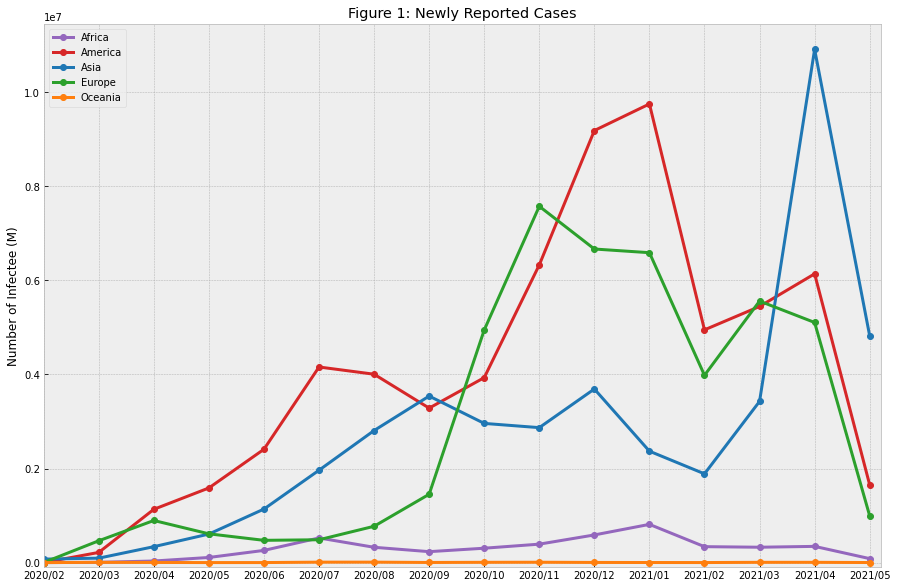

In [10]:
continent_list = continent_new_case['CONTINENT_NAME'].unique()
text_x_position = len(continent_new_case['MONTH_YEAR'].unique()) - 0.8
color_list = ['tab:purple', 'tab:red', 'tab:blue', 'tab:green', 'tab:orange']
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [15, 10]

# use for loop to create a line graph for each continent
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH_YEAR', 'Confirmed_Cases', data=continent_new_case.loc[continent_new_case['CONTINENT_NAME']==continent],
             c=color, label=continent, marker='o', linewidth=3)
    
plt.legend()
plt.ylim(-100000, max(continent_new_case['Confirmed_Cases'])*1.05)
plt.xlim(1, text_x_position)
plt.title('Figure 1: Newly Reported Cases')
plt.ylabel('Number of Infectee (M)')
plt.show()

To be clear each plot **doesn't** represent the sum of monthly cases. It's a quantity of newly reported cases.
### Observations
* Both America and Europe experienced fast growth from Sep 2020 to Jan 2020
* The immediate impact of vaccination in Jan 2021 can be observed with the sharp decline of newly reported cases in Feb 2021
* The steepest slope is Asia's March 2021 - April 2021

* **Monthly aggregate cases**

In [11]:
# create a list of total of new cases for each time period
aggregate_dict = dict()

case_tracker = 0
for continent in continent_list:
    aggregate_list = []
    ## forming a dict of aggregate cases by timeline (monthly)
    monthly_cases = continent_new_case.loc[continent_new_case['CONTINENT_NAME'] == continent]['Confirmed_Cases']
    for case in monthly_cases:
        case_tracker += case
        aggregate_list.append(case_tracker)
    case_tracker = 0
    aggregate_dict[continent] = aggregate_list

#this is to add it to continent_new_case 
all_aggregate_list = []
for continent in aggregate_dict:
    all_aggregate_list += aggregate_dict[continent]

continent_new_case['AGGREGATE_CASES'] = all_aggregate_list
print(continent_new_case.head(10))

  CONTINENT_NAME MONTH_YEAR  Confirmed_Cases  AGGREGATE_CASES
0         Africa    2020/01                0                0
1         Africa    2020/02                3                3
2         Africa    2020/03             6119             6122
3         Africa    2020/04            33590            39712
4         Africa    2020/05           109017           148729
5         Africa    2020/06           259301           408030
6         Africa    2020/07           523672           931702
7         Africa    2020/08           325513          1257215
8         Africa    2020/09           232494          1489709
9         Africa    2020/10           305792          1795501


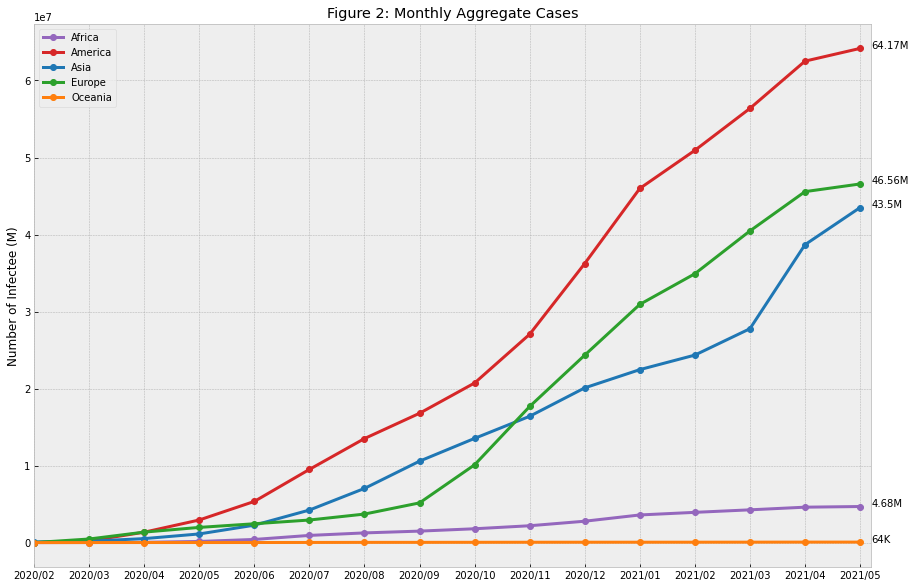

In [12]:
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH_YEAR', 'AGGREGATE_CASES', data=continent_new_case.loc[continent_new_case['CONTINENT_NAME']==continent],
             c=color, label=continent, marker='o', linewidth=3)

max_continent = []
for continent in aggregate_dict:
    max_continent.append(max(aggregate_dict[continent]))

# create labels 
for y in max_continent:
    if y >= 1000000:
        plt.text(text_x_position, y, str(round(y/1000000, 2)) +'M')
    else:
        plt.text(text_x_position, y, str(round(y/1000)) +'K')

plt.rcParams['figure.figsize'] = [15, 10]
plt.legend()
plt.xlim(1, text_x_position)
plt.title('Figure 2: Monthly Aggregate Cases')
plt.ylabel('Number of Infectee (M)')
plt.show()

### Observations
* America is by far the *most* dangerous continent to travel in the current state - **fastest growth rate** since April of 2020
* The slopes are getting gentler near the end - due to vaccination
* Asia could surpass Europe in aggregate cases in the near future
* Oceania & Africa are experiencing steady and gradual increase

### Counting Deaths of each Continent

In [13]:
continent_death = covid[['CONTINENT_NAME', 'PEOPLE_DEATH_NEW_COUNT', 'MONTH_YEAR']
                       ].groupby(['CONTINENT_NAME', 'MONTH_YEAR'], as_index=False).sum()
continent_death.rename(columns = {'PEOPLE_DEATH_NEW_COUNT' : 'NEW_DEATH'}, inplace=True)

DEATH_AGGREGATE = []
death_count = 0
for continent in continent_list:
    for item, death in zip(continent_death['CONTINENT_NAME'], continent_death['NEW_DEATH']):
        if continent == item:
            death_count += death
            DEATH_AGGREGATE.append(death_count)
        else:
            death_count = 0

continent_death['DEATH_AGGREGATE'] = DEATH_AGGREGATE
print(continent_death)

   CONTINENT_NAME MONTH_YEAR  NEW_DEATH  DEATH_AGGREGATE
0          Africa    2020/01          0                0
1          Africa    2020/02          0                0
2          Africa    2020/03        201              201
3          Africa    2020/04       1437             1638
4          Africa    2020/05       2606             4244
5          Africa    2020/06       5939            10183
6          Africa    2020/07       9542            19725
7          Africa    2020/08      10136            29861
8          Africa    2020/09       6060            35921
9          Africa    2020/10       7000            42921
10         Africa    2020/11       9160            52081
11         Africa    2020/12      13484            65565
12         Africa    2021/01      25513            91078
13         Africa    2021/02      12782           103860
14         Africa    2021/03       9175           113035
15         Africa    2021/04       9067           122102
16         Africa    2021/05   

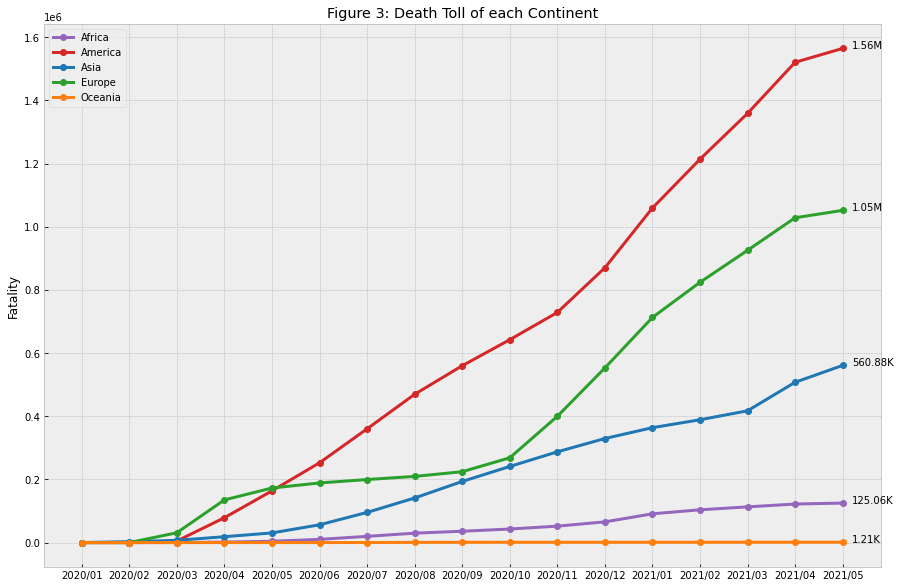

In [14]:
plt.rcParams['figure.figsize'] = [15, 10]

# generating a graph of each continent
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH_YEAR', 'DEATH_AGGREGATE', data=continent_death.loc[continent_death['CONTINENT_NAME']==continent],
             c=color, label=continent, marker='o', linewidth=3)

# store the latest reported death cases (accumulation)
max_death = []
for continent in continent_list:
    max_death.append(continent_death.loc[continent_death['CONTINENT_NAME'] == continent]['DEATH_AGGREGATE'].max())

text_x_position = len(continent_death['MONTH_YEAR'].unique()) - 0.8

# generating texts of latest reported death cases (accumulation)
for y in max_death:
    if y >= 1000000:
        plt.text(text_x_position, y, str(round(y/1000000, 2)) +'M')
    elif y < 1000000 and y >= 1000:
        plt.text(text_x_position, y, str(round(y/1000, 2)) +'K')
    else:
        plt.text(text_x_position, y, str(y))

plt.legend()
plt.title('Figure 3: Death Toll of each Continent')
plt.ylabel('Fatality')
plt.show()

### Observations
* Figure 3 is quite reflective of figure 2
* America, Europe, and Asia have experienced rapid growth rate of death cases until April of 2021.
* With the deployment of mass vaccination around the globe, the decline in death cases can be observed.

### Mortality Rate

In [15]:
def death_rate(df, continent, avg=False):
    '''
    returns mortality rate(s) of a given country or countries
    
        Args:
            df (DataFrame): a dataframe that contains info of continent names, # of infectee, and # of death cases
            continent (str or list of str): a continent or a list of continents
            avg (Bool): If average of 
        Return:
             death rate of continent(s) or an average death rate of continents
    '''
    # if calculating death rate of a continent, find the lastest updates of death and infected population
    if type(continent) == str:
        temp = df.loc[df['CONTINENT_NAME'] == continent]
        return '{}%'.format(round(temp['PEOPLE_DEATH_COUNT'].max()/temp['PEOPLE_POSITIVE_CASES_COUNT'].max()*100, 2))

    # finding avg is wanted, return an average of all continents in a given list
    elif avg:
        continents_death_rate = []
        for item in continent:
            continents_death_rate.append(
                df.loc[df['CONTINENT_NAME'] == item]['PEOPLE_DEATH_COUNT'].max()/
                df.loc[df['CONTINENT_NAME'] == item]['PEOPLE_POSITIVE_CASES_COUNT'].max()*100)
        return str(round(np.array(continents_death_rate).mean(), 2)) + '%' 
    
    # if calculating death rate of continents, find all continent's death rates
    else:
        continents_death_rate = []
        for item in continent:
            continents_death_rate.append(str(round(
                df.loc[df['CONTINENT_NAME'] == item]['PEOPLE_DEATH_COUNT'].max()/
                df.loc[df['CONTINENT_NAME'] == item]['PEOPLE_POSITIVE_CASES_COUNT'].max()*100, 2)
                                            ) + '%'
                                        )
        return continents_death_rate

In [16]:
for continent in continent_list:
    print(f"Mortality rate of Covid-19 in {continent}: {death_rate(covid, continent)}")
print(f'===============\nAverage mortality rate of Covid-19: {death_rate(covid, continent_list, avg=True)}')

Mortality rate of Covid-19 in Africa: 3.43%
Mortality rate of Covid-19 in America: 2.78%
Mortality rate of Covid-19 in Asia: 1.09%
Mortality rate of Covid-19 in Europe: 2.23%
Mortality rate of Covid-19 in Oceania: 3.99%
Average mortality rate of Covid-19: 2.7%


If we were to only consider mortality rate, ***Oceania*** would be the most dangerous continent to travel with the highest mortality rate of ***3.99%*** while ***Asia*** would be the safest with lowest of ***1.09%***.

But, as seen above, Oceania scored the lowest death toll and confirmed cases as population in the continent is a lot less when compared to others. Hence, it should make more sense when both total death and mortality rate are considered.

If we have to pick the most dangerous continent to travel, it would be ***America*** with 64 million cases and 2.78% mortality rate. On the other hand, ***Oceania*** with 64,000 cases and 3.99% mortality rate would be considered the safest. 

In [17]:
total_all = covid[['MONTH_YEAR','PEOPLE_POSITIVE_NEW_CASES_COUNT',
                   'PEOPLE_DEATH_NEW_COUNT']].groupby(['MONTH_YEAR'], as_index=False).sum()
total_positive_list = []
total_death_list = []
count_positive = 0
count_death = 0
for positive, death in zip(total_all['PEOPLE_POSITIVE_NEW_CASES_COUNT'], total_all['PEOPLE_DEATH_NEW_COUNT']):
    count_positive += positive
    count_death += death
    total_positive_list.append(count_positive)
    total_death_list.append(count_death)
total_all['TOTAL_POSITIVE_CASE'] = total_positive_list
total_all['TOTAL_DEATH'] = total_death_list
total_all

,MONTH_YEAR,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_NEW_COUNT,TOTAL_POSITIVE_CASE,TOTAL_DEATH
0,2020/01,9926,213,9926,213
1,2020/02,75427,2723,85353,2936
2,2020/03,785887,40501,871240,43437
3,2020/04,2402627,190874,3273867,234311
4,2020/05,2914180,137255,6188047,371566
5,2020/06,4280308,136461,10468355,508027
6,2020/07,7139940,167180,17608295,675207
7,2020/08,7918633,175519,25526928,850726
8,2020/09,8511391,163886,34038319,1014612
9,2020/10,12146595,180930,46184914,1195542


### Worldwide Aggregate

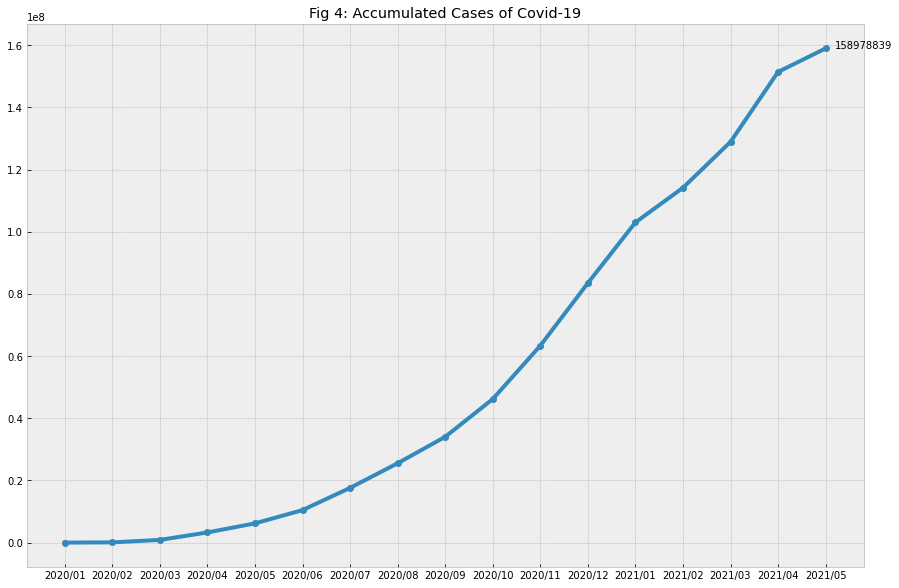

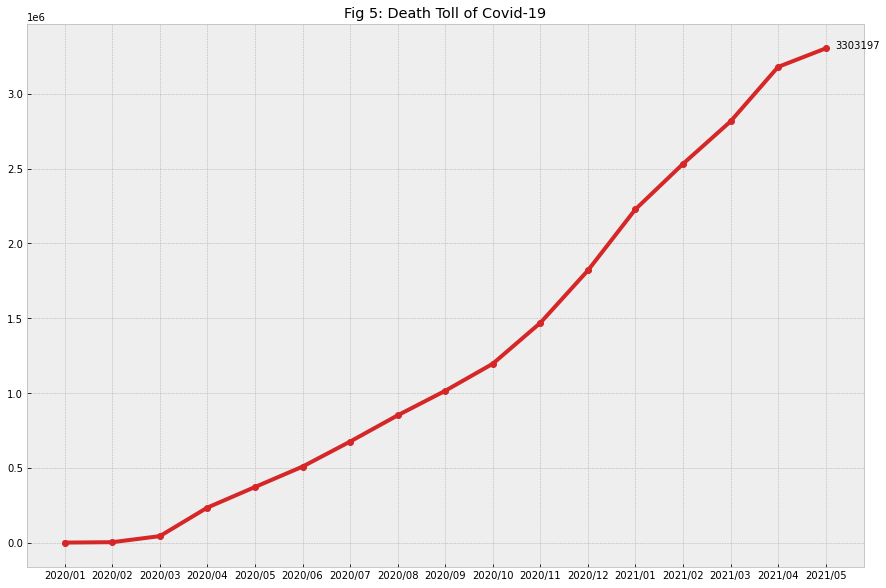

In [18]:
plt.plot('MONTH_YEAR' ,'TOTAL_POSITIVE_CASE', data=total_all, linewidth=4, marker='o')
plt.title('Fig 4: Accumulated Cases of Covid-19')
latest_report_positive = total_all['TOTAL_POSITIVE_CASE'].max()
plt.text(text_x_position, latest_report_positive, str(latest_report_positive))
plt.show()

plt.plot('MONTH_YEAR' ,'TOTAL_DEATH', data=total_all, linewidth=4, marker='o', c='tab:red')
plt.title('Fig 5: Death Toll of Covid-19')
latest_report_death = total_all['TOTAL_DEATH'].max()
plt.text(text_x_position, latest_report_death, str(latest_report_death))
plt.show()

### World Map Timeline Visualization

In [19]:
c_monthly = covid[['COUNTRY_SHORT_NAME', 'COUNTRY_ALPHA_3_CODE', 'MONTH_YEAR', 'PEOPLE_POSITIVE_NEW_CASES_COUNT']
                 ].groupby(['COUNTRY_SHORT_NAME', 'COUNTRY_ALPHA_3_CODE', 'MONTH_YEAR'], as_index=False).sum()
country_list = c_monthly['COUNTRY_SHORT_NAME'].unique()
all_agg = []
total = 0

for country in country_list:
    temp = c_monthly[c_monthly['COUNTRY_SHORT_NAME'] == country]
    total = 0
    for case in temp['PEOPLE_POSITIVE_NEW_CASES_COUNT']:
        total += case
        all_agg.append(total)

c_monthly['AGGREGATE_CASE'] = all_agg

init_notebook_mode(connected=True)
fig = px.choropleth(data_frame = c_monthly,
                    locations= "COUNTRY_ALPHA_3_CODE",
                    color= "AGGREGATE_CASE",  # value in column 'Confirmed' determines color
                    hover_name= "COUNTRY_SHORT_NAME",
                    color_continuous_scale= 'Reds',  #  color scale red, yellow green
                    animation_frame= "MONTH_YEAR")

fig.show()

<Figure size 1080x720 with 0 Axes>

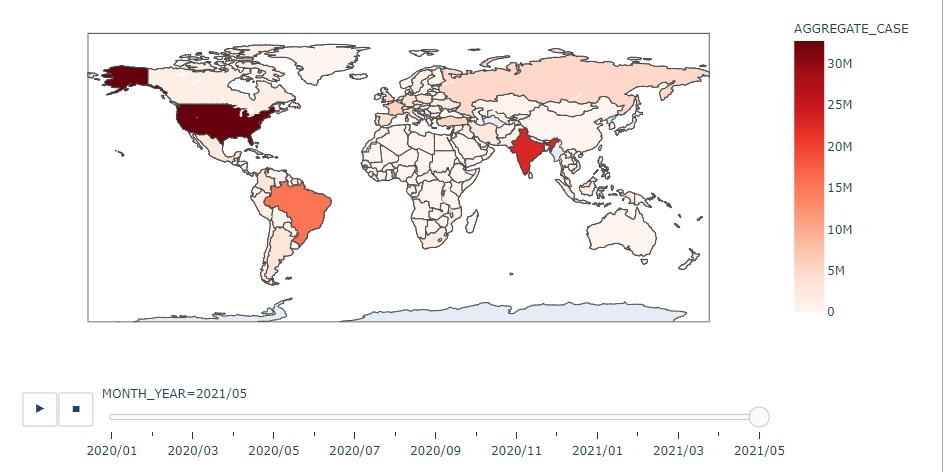